In [6]:
from classes import *

In [7]:
m = Measurments('TiN_HZO_1.1')
p = Process_DC_IV(m.get_abspath())
d = Draw_DC_IV(p, m)
#d.all()

In [8]:
k16_100 = m.get_contact_dict('K16-100')
k16_75 = m.get_contact_dict('K16-75')
k16_50 = m.get_contact_dict('K16-50')
k16_25 = m.get_contact_dict('K16-25')
k16_10 = m.get_contact_dict('K16-10')

0

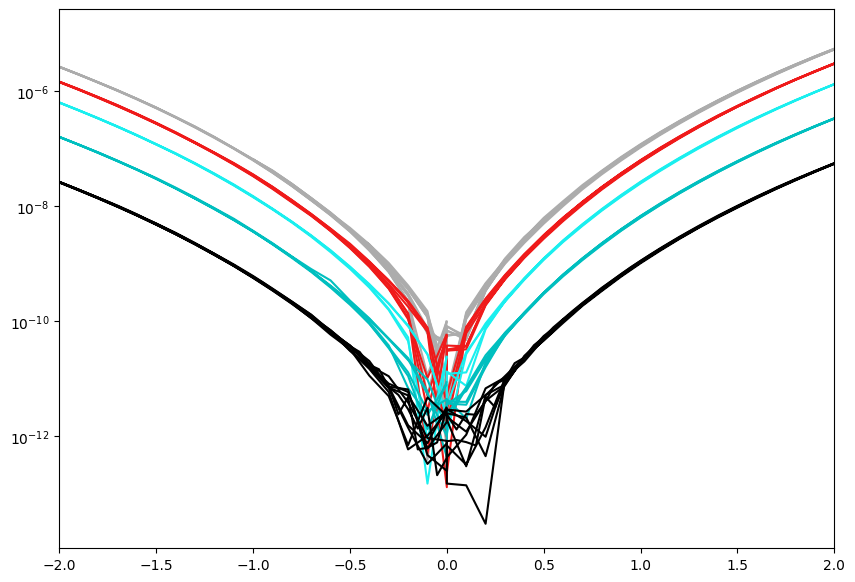

In [9]:
fig, ax = plt.subplots(figsize = [10, 7])

d.multiple(k16_100, ax)
d.multiple(k16_75, ax, color='#ef1a1a')
d.multiple(k16_50, ax, color='#1aefef')
d.multiple(k16_25, ax, color='c')
d.multiple(k16_10, ax, color='k')

ax.set_yscale('log')
ax.set_xlim([-2,2])
#ax.set_ylim([-1,1])
len(ax.get_lines())

In [10]:
np.mean(p.get_on_off_current(k16_100, 0.5)['I_on'])/ np.mean(p.get_on_off_current(k16_10, 0.5)['I_on'])

113.80538151573086